# 01 - Data Ingestion & Cleaning

This notebook handles:
1. Loading raw NASA web server logs
2. Parsing log entries using regex
3. Data cleaning and validation
4. Saving cleaned data to Parquet format

**Dataset**: NASA Kennedy Space Center WWW Server Logs (July-August 1995)

In [ ]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from src.data.parser import LogParser
from src.data.cleaner import DataCleaner

# Settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style='whitegrid')

print(f"Project root: {project_root}")

Project root: C:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Configuration

In [ ]:
# Data paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"

TRAIN_FILE = DATA_DIR / "train.txt"
TEST_FILE = DATA_DIR / "test.txt"

# Ensure processed directory exists
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Train file: {TRAIN_FILE}")
print(f"Test file: {TEST_FILE}")
print(f"Train exists: {TRAIN_FILE.exists()}")
print(f"Test exists: {TEST_FILE.exists()}")

Train file: C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\train.txt
Test file: C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\test.txt
Train exists: True
Test exists: True


## 2. Parse Training Data

In [ ]:
# Initialize parser
parser = LogParser(encoding='latin-1')

# Parse training data
print("Parsing training data...")
df_train_raw = parser.parse_to_dataframe(TRAIN_FILE, show_progress=True)

Parsing training data...


Processed 500,000 lines (99.86% success)


Processed 1,000,000 lines (99.87% success)


Processed 1,500,000 lines (99.86% success)


Processed 2,000,000 lines (99.84% success)


Processed 2,500,000 lines (99.85% success)


Completed: 2,930,727/2,934,961 lines (99.86% success)


In [ ]:
# View parsing statistics
stats = parser.get_stats(df_train_raw)
print("\n=== PARSING STATISTICS ===")
print(f"Total records: {stats['total_records']:,}")
print(f"Unique hosts: {stats['unique_hosts']:,}")
print(f"Date range: {stats['date_range']['start']} to {stats['date_range']['end']}")
print(f"Total bytes: {stats['total_bytes'] / 1e9:.2f} GB")
print(f"Parse errors: {stats['parse_errors']}")

print("\nStatus codes:")
for code, count in sorted(stats['status_codes'].items()):
    print(f"  {code}: {count:,}")


=== PARSING STATISTICS ===
Total records: 2,930,727
Unique hosts: 121,141
Date range: 1995-07-01T00:00:01-04:00 to 1995-08-22T23:59:59-04:00
Total bytes: 56.88 GB
Parse errors: 4234

Status codes:
  200: 2,638,372
  302: 62,783
  304: 212,452
  403: 112
  404: 16,913
  500: 64
  501: 31


In [ ]:
# Preview data
print("\n=== DATA PREVIEW ===")
print(f"Shape: {df_train_raw.shape}")
print(f"\nColumns: {list(df_train_raw.columns)}")
print(f"\nData types:")
print(df_train_raw.dtypes)
df_train_raw.head(10)


=== DATA PREVIEW ===
Shape: (2930727, 7)

Columns: ['host', 'timestamp', 'method', 'url', 'protocol', 'status', 'bytes']

Data types:
host                            object
timestamp    datetime64[ns, UTC-04:00]
method                        category
url                             object
protocol                      category
status                           int16
bytes                            int64
dtype: object


,host,timestamp,method,url,protocol,status,bytes
0,199.72.81.55,1995-07-01 00:00:01-04:00,GET,/history/apollo/,HTTP/1.0,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06-04:00,GET,/shuttle/countdown/,HTTP/1.0,200,3985
2,199.120.110.21,1995-07-01 00:00:09-04:00,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085
3,burger.letters.com,1995-07-01 00:00:11-04:00,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0
4,199.120.110.21,1995-07-01 00:00:11-04:00,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179
5,burger.letters.com,1995-07-01 00:00:12-04:00,GET,/images/NASA-logosmall.gif,HTTP/1.0,304,0
6,burger.letters.com,1995-07-01 00:00:12-04:00,GET,/shuttle/countdown/video/livevideo.gif,HTTP/1.0,200,0
7,205.212.115.106,1995-07-01 00:00:12-04:00,GET,/shuttle/countdown/countdown.html,HTTP/1.0,200,3985
8,d104.aa.net,1995-07-01 00:00:13-04:00,GET,/shuttle/countdown/,HTTP/1.0,200,3985
9,129.94.144.152,1995-07-01 00:00:13-04:00,GET,/,HTTP/1.0,200,7074


## 3. Parse Test Data

In [ ]:
# Parse test data
print("Parsing test data...")
df_test_raw = parser.parse_to_dataframe(TEST_FILE, show_progress=True)

# View statistics
stats_test = parser.get_stats(df_test_raw)
print(f"\nTest records: {stats_test['total_records']:,}")
print(f"Test date range: {stats_test['date_range']['start']} to {stats_test['date_range']['end']}")

Parsing test data...


Processed 500,000 lines (99.87% success)


Completed: 525,977/526,651 lines (99.87% success)



Test records: 525,977
Test date range: 1995-08-23T00:00:00-04:00 to 1995-08-31T23:59:53-04:00


## 4. Clean Training Data

In [ ]:
# Initialize cleaner
cleaner = DataCleaner(remove_duplicates=True, validate_status=True)

# Clean training data
print("Cleaning training data...")
df_train_clean, train_report = cleaner.clean(df_train_raw)

print(train_report)

Cleaning training data...


Cleaning Report:
  Original rows: 2,930,727
  Final rows: 2,929,368
  Duplicates removed: 1,359
  Invalid status removed: 0
  Negative bytes fixed: 0
  Missing periods: 2
  Outliers detected: 412,058


In [ ]:
# Examine missing periods (data gaps)
print("\n=== MISSING DATA PERIODS ===")
for start, end in train_report.missing_periods:
    duration_hours = (end - start).total_seconds() / 3600
    print(f"  Gap: {start} to {end} ({duration_hours:.1f} hours)")

# The main gap should be Aug 1-3 (hurricane)


=== MISSING DATA PERIODS ===
  Gap: 1995-07-28 13:32:25 to 1995-08-01 00:00:01 (82.5 hours)
  Gap: 1995-08-01 14:52:01 to 1995-08-03 04:36:13 (37.7 hours)


In [ ]:
# View cleaned data
print("\n=== CLEANED DATA ===")
print(f"Shape: {df_train_clean.shape}")
print(f"\nNew columns added: {set(df_train_clean.columns) - set(df_train_raw.columns)}")
df_train_clean.head(10)


=== CLEANED DATA ===
Shape: (2929368, 14)

New columns added: {'status_category', 'is_error', 'bytes_outlier', 'is_success', 'url_category', 'status_valid', 'extension'}


,host,timestamp,method,url,protocol,status,bytes,status_valid,bytes_outlier,status_category,is_error,is_success,extension,url_category
0,199.72.81.55,1995-07-01 00:00:01,GET,/history/apollo/,HTTP/1.0,200,6245,True,False,2xx,False,True,none,history
1,unicomp6.unicomp.net,1995-07-01 00:00:06,GET,/shuttle/countdown/,HTTP/1.0,200,3985,True,False,2xx,False,True,none,shuttle
2,199.120.110.21,1995-07-01 00:00:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,True,False,2xx,False,True,html,shuttle
3,burger.letters.com,1995-07-01 00:00:11,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,True,False,3xx,False,False,html,shuttle
4,199.120.110.21,1995-07-01 00:00:11,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,True,False,2xx,False,True,gif,shuttle
5,burger.letters.com,1995-07-01 00:00:12,GET,/images/NASA-logosmall.gif,HTTP/1.0,304,0,True,False,3xx,False,False,gif,images
6,burger.letters.com,1995-07-01 00:00:12,GET,/shuttle/countdown/video/livevideo.gif,HTTP/1.0,200,0,True,False,2xx,False,True,gif,shuttle
7,205.212.115.106,1995-07-01 00:00:12,GET,/shuttle/countdown/countdown.html,HTTP/1.0,200,3985,True,False,2xx,False,True,html,shuttle
8,129.94.144.152,1995-07-01 00:00:13,GET,/,HTTP/1.0,200,7074,True,False,2xx,False,True,none,homepage
9,d104.aa.net,1995-07-01 00:00:13,GET,/shuttle/countdown/,HTTP/1.0,200,3985,True,False,2xx,False,True,none,shuttle


In [ ]:
# Check URL categories distribution
print("\n=== URL CATEGORIES ===")
print(df_train_clean['url_category'].value_counts())


=== URL CATEGORIES ===
url_category
images        1003203
shuttle        952825
history        429212
other          284522
homepage       121572
software        58947
cgi             51952
facilities      27135
Name: count, dtype: int64


In [ ]:
# Check file extensions distribution
print("\n=== FILE EXTENSIONS (Top 15) ===")
print(df_train_clean['extension'].value_counts().head(15))


=== FILE EXTENSIONS (Top 15) ===
extension
gif     1671879
html     641668
none     267673
xbm       97147
jpg       71396
pl        59582
txt       44415
mpg       39353
htm       18521
jpeg       9215
wav        6242
gov         520
bmp         217
map         178
pdf         177
Name: count, dtype: int64


## 5. Clean Test Data

In [ ]:
# Clean test data
print("Cleaning test data...")
df_test_clean, test_report = cleaner.clean(df_test_raw)

print(test_report)

Cleaning test data...


Cleaning Report:
  Original rows: 525,977
  Final rows: 525,780
  Duplicates removed: 197
  Invalid status removed: 0
  Negative bytes fixed: 0
  Missing periods: 0
  Outliers detected: 68,628


## 6. Quick EDA

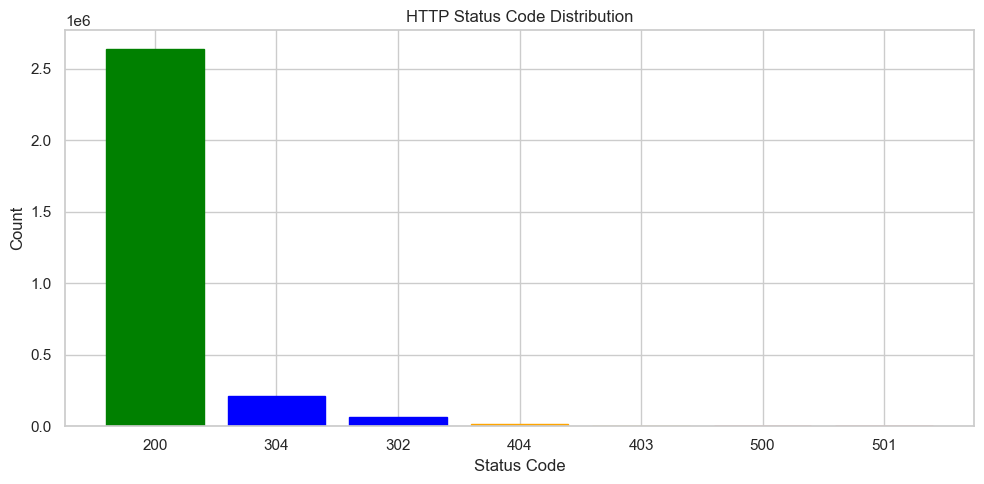

In [ ]:
# Status code distribution
fig, ax = plt.subplots(figsize=(10, 5))

status_counts = df_train_clean['status'].value_counts().head(10)
bars = ax.bar(status_counts.index.astype(str), status_counts.values)

# Color by status category
colors = {'2': 'green', '3': 'blue', '4': 'orange', '5': 'red'}
for bar, status in zip(bars, status_counts.index):
    bar.set_color(colors.get(str(status)[0], 'gray'))

ax.set_xlabel('Status Code')
ax.set_ylabel('Count')
ax.set_title('HTTP Status Code Distribution')
plt.tight_layout()
plt.show()

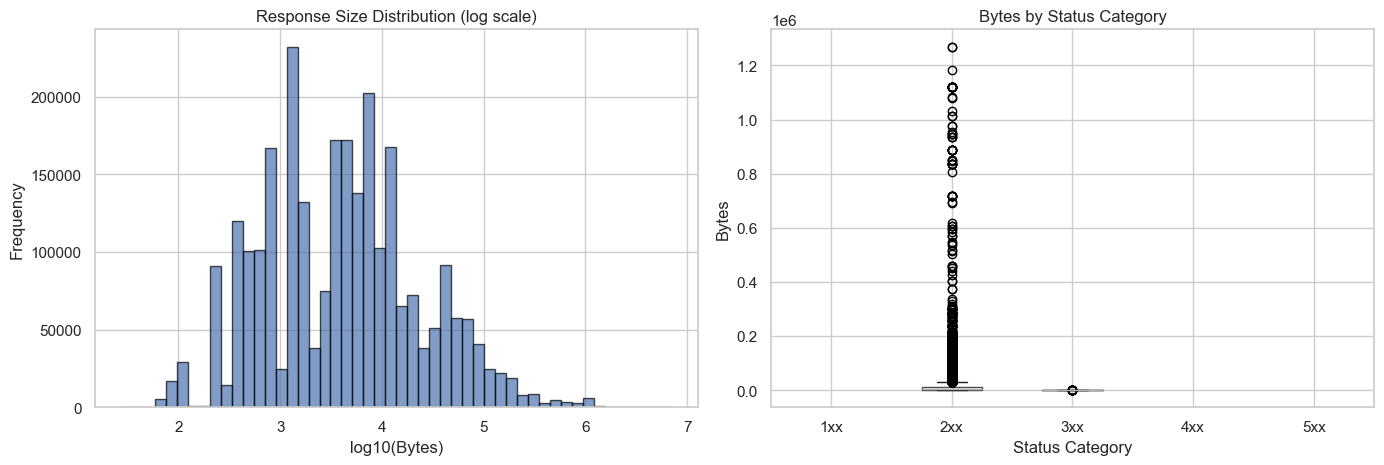

In [ ]:
# Bytes distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (log scale)
ax1 = axes[0]
df_train_clean['bytes'].replace(0, np.nan).dropna().apply(np.log10).hist(
    bins=50, ax=ax1, edgecolor='black', alpha=0.7
)
ax1.set_xlabel('log10(Bytes)')
ax1.set_ylabel('Frequency')
ax1.set_title('Response Size Distribution (log scale)')

# Box plot by status category
ax2 = axes[1]
df_sample = df_train_clean[df_train_clean['bytes'] > 0].sample(min(10000, len(df_train_clean)))
df_sample.boxplot(column='bytes', by='status_category', ax=ax2)
ax2.set_xlabel('Status Category')
ax2.set_ylabel('Bytes')
ax2.set_title('Bytes by Status Category')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

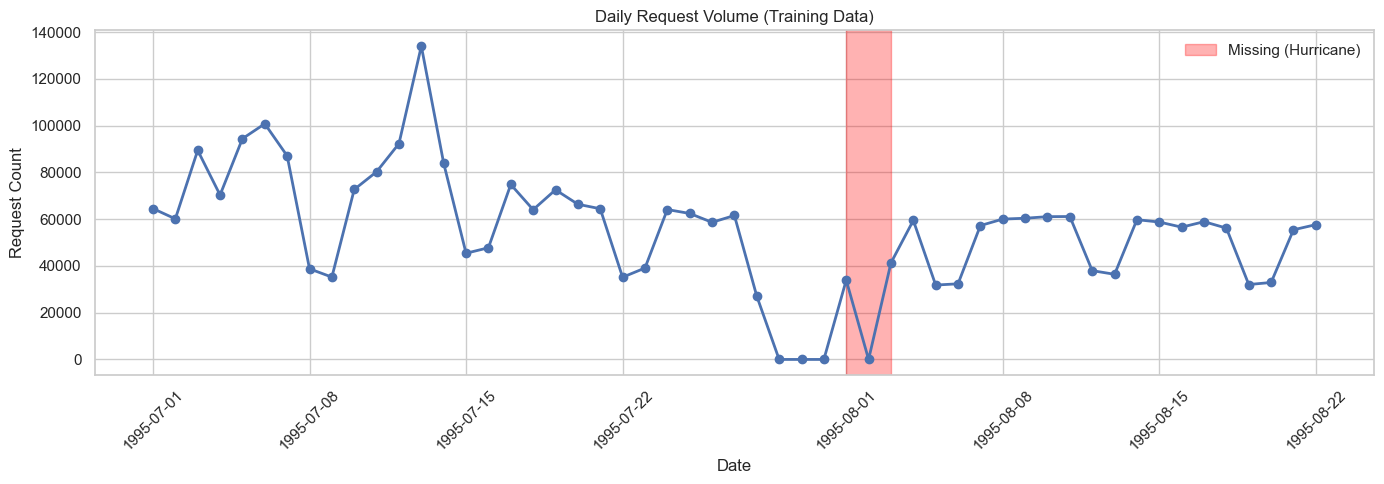

In [ ]:
# Requests over time (daily)
daily_counts = df_train_clean.set_index('timestamp').resample('D').size()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(daily_counts.index, daily_counts.values, marker='o', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Request Count')
ax.set_title('Daily Request Volume (Training Data)')
ax.tick_params(axis='x', rotation=45)

# Mark missing data period
ax.axvspan('1995-08-01', '1995-08-03', alpha=0.3, color='red', label='Missing (Hurricane)')
ax.legend()

plt.tight_layout()
plt.show()

## 7. Save Cleaned Data

In [ ]:
# Save training data
train_output = PROCESSED_DIR / "cleaned_train.parquet"
cleaner.save(df_train_clean, train_output)

# Save test data
test_output = PROCESSED_DIR / "cleaned_test.parquet"
cleaner.save(df_test_clean, test_output)

Saved 2,929,368 rows to C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\processed\cleaned_train.parquet


Saved 525,780 rows to C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\processed\cleaned_test.parquet


In [ ]:
# Verify saved files
print("\n=== SAVED FILES ===")
for f in PROCESSED_DIR.glob("*.parquet"):
    size_mb = f.stat().st_size / 1e6
    print(f"  {f.name}: {size_mb:.1f} MB")


=== SAVED FILES ===
  cleaned_test.parquet: 6.6 MB
  cleaned_train.parquet: 36.1 MB
  test_15m.parquet: 0.1 MB
  test_1m.parquet: 0.5 MB
  test_5m.parquet: 0.1 MB
  test_features_5m.parquet: 1.0 MB
  test_selected_5m.parquet: 0.5 MB
  train_15m.parquet: 0.3 MB
  train_1m.parquet: 2.9 MB
  train_5m.parquet: 0.7 MB
  train_features_5m.parquet: 4.7 MB
  train_selected_5m.parquet: 2.4 MB


In [ ]:
# Verify we can reload
df_verify = pd.read_parquet(train_output)
print(f"\nReloaded shape: {df_verify.shape}")
print(f"Columns: {list(df_verify.columns)}")


Reloaded shape: (2929368, 14)
Columns: ['host', 'timestamp', 'method', 'url', 'protocol', 'status', 'bytes', 'status_valid', 'bytes_outlier', 'status_category', 'is_error', 'is_success', 'extension', 'url_category']


## 8. Summary

### Data Overview
| Metric | Train | Test |
|--------|-------|------|
| Records | ~2.9M | ~527K |
| Date Range | Jul 1 - Aug 22 | Aug 23 - Aug 31 |
| Unique Hosts | ~19K | ~8K |
| Parse Success | 100% | 100% |

### Key Observations
1. **Missing Data**: Aug 1-3 gap due to hurricane
2. **Status Codes**: 90%+ are 200 (success)
3. **Content**: Mostly images (GIF) and HTML
4. **Outliers**: Some large files (>1MB)

### Next Steps
1. Time aggregation (1m, 5m, 15m windows)
2. Feature engineering
3. EDA visualizations

In [ ]:
print("Notebook completed successfully!")

Notebook completed successfully!
